In [1]:
import json
from langdetect import detect
import os
import requests
import datetime
from dateutil import parser
import pytz
import matplotlib.pyplot as plt
import numpy
from sklearn import linear_model

------------ START PARSING TWEETS --------------

Filter tweets from movie_tweet.txt to each movies, detecting the language of the tweets at the same time (might take a while)

In [7]:
if not os.path.exists('all_tweets'):
    os.makedirs('all_tweets')
    
f_in = open('movie_tweet.txt', 'r')
line = f_in.readline()
# print line
j = json.loads(line)
movie_tweets = j["movie_tweet"]
for movie_tweet in movie_tweets:
    title = movie_tweet["title"]
    f_out = open('all_tweets/all_tweet_' + title + '.txt', 'w')
    output = []
    tweets = movie_tweet["tweets"]
    a = 0
    for tweet in tweets:
        if tweet["text"] == "Unfriended@RileyHaralson":
            tweet_out = {"created_at": tweet["created_at"], "text": tweet["text"], "language": "en"}
        else:
            tweet_out = {"created_at": tweet["created_at"], "text": tweet["text"], "language": detect(tweet["text"])}
        output.append(tweet_out)
    f_out.write(json.dumps(output))
    f_out.close()
f_in.close()


In [2]:
movies = ['alex of venice', 'beyond the reach', 'child 44', 'dead lands', 'felix and meira', 'monkey kingdom',
          'monsters', 'paul blart', 'true story', 'unfriended']

Extract only the tweets from all the tweets, to be sent to for content analysis

In [3]:
if not os.path.exists('just_tweets'):
    os.makedirs('just_tweets')
    
for movie in movies:
    f_in = open('all_tweets/all_tweet_' + movie + '.txt', 'r')
    line = f_in.readline()
    tweets = json.loads(line)
    
    f_out = open('just_tweets/just_tweet_' + movie + '.txt', 'w')
    
    jt = []
    for tweet in tweets:
        jt.append(tweet["text"])
    
    f_out.write(json.dumps(jt))
    f_out.close()
    f_in.close()

Split the just tweets into several files. Done because limitation of sentiment analysis API (files maximum 1MB)

In [4]:
if not os.path.exists('split_tweets'):
    os.makedirs('split_tweets')
    
chunk = [1, 1, 1, 1, 1, 1, 2, 10, 10, 30]
def chunks(l, n):
    n = max(1, n)
    return [l[i:i + n] for i in range(0, len(l), n)]

for i in range(0, len(movies)):
    f_in = open('just_tweets/just_tweet_' + movies[i] + '.txt', 'r')
    line = f_in.readline()
    json_tweet = json.loads(line)

    json_tweet2 = chunks(json_tweet, len(json_tweet)/chunk[i])
    for j in range(0, len(json_tweet2)):
        f_out = open('split_tweets/split_tweet_' + movies[i] + '_' + str(j) + '.txt', 'w')
        f_out.write(json.dumps(json_tweet2[j]))
        f_out.close()

    f_in.close()

Send the tweets for sentiment analysis, then joining them to single files per movie again

In [5]:
if not os.path.exists('sentiment_tweets'):
    os.makedirs('sentiment_tweets')
    
def sentiment_analysis(tw):
    url = 'http://sentiment.vivekn.com/api/batch/'
    headers = {'content-type': 'application/json'}

    response = requests.post(url, data=json.dumps(tw), headers=headers)
    return response.text

for i in range(0, len(movies)):
    f_out = open('sentiment_tweets/sentiment_tweet_' + movies[i] + '.txt', 'w')
    output = {"tweets": []}

    if chunk[i] <= 2:
        chunk[i] -= 1
    for a in range(0, chunk[i]+1):
        f_in = open('split_tweets/split_tweet_' + movies[i] + '_' + str(a) + '.txt', 'r')

        line = f_in.readline()
        # print line
        json_tweet = json.loads(line)
        # print j
        sentiment = sentiment_analysis(json_tweet)
        json_sentiment = json.loads(sentiment)


        for j in range(0, len(json_tweet)):
            tweet_output = {"text": json_tweet[j], "sentiment": json_sentiment[j]["result"],
                            "confidence": json_sentiment[j]["confidence"]}
            output["tweets"].append(tweet_output)
        f_in.close()

    f_out.write(json.dumps(output))
    f_out.close()

Combining all the tweets information (text, created_at, language, sentiment, confidence) into one complete file for further processing

In [6]:
if not os.path.exists('complete_tweets'):
    os.makedirs('complete_tweets')
    
for movie in movies:
    f_in = open('all_tweets/all_tweet_' + movie + '.txt', 'r')
    line = f_in.readline()
    j = json.loads(line)

    f_in2 = open('sentiment_tweets/sentiment_tweet_' + movie + '.txt', 'r')
    line2 = f_in2.readline()
    j2 = json.loads(line2)
    j2 = j2["tweets"]

    f_out = open('complete_tweets/complete_tweet_' + movie + ".txt", 'w')

    output = {"movie": movie, "tweets": []}
    for i in range(0, len(j)):
        tweet_out = {"created_at": j[i]["created_at"], "text": j[i]["text"], "language": j[i]["language"],
                     "sentiment" : j2[i]["sentiment"], "confidence" : j2[i]["confidence"]}
        output["tweets"].append(tweet_out)

    f_out.write(json.dumps(output))
    f_out.close()
    f_in.close()
    f_in2.close()

----------- END PARSING TWEETS -------------

--------- START FILTERING TWEETS ------------

Filter the tweets by joining them based on the 10 minutes interval of the IMDb rating data. Also remove the non english tweets

In [7]:
if not os.path.exists('filtered_tweets'):
    os.makedirs('filtered_tweets')
    
utc=pytz.UTC

for movie in movies:
    f_in = open('complete_tweets/complete_tweet_' + movie + ".txt", 'r')
    line = f_in.readline()
    tweets = json.loads(line)["tweets"]

    f_out = open('filtered_tweets/filtered_tweet_' + movie + ".txt", 'w')

    output = {"movie": movie, "sentiments": []}
    start_date = datetime.datetime(2015,4,16,13,36,0)
    end_date = datetime.datetime(2015,4,24,9,36,0)
    date = start_date
    sentiment = 0
    num_tweet = 0
    current_tweet = 0

    while date <= end_date:
        if current_tweet < len(tweets):
            if parser.parse(tweets[current_tweet]["created_at"]) > utc.localize(date):
                if num_tweet != 0:
                    sentiment /= num_tweet
                sentiment_output = {"created_at": str(utc.localize(date)), "sentiment": sentiment}
                output["sentiments"].append(sentiment_output)
                date = date + datetime.timedelta(minutes=10)
                sentiment = 0
                num_tweet = 0
            else:
                if tweets[current_tweet]["language"] == 'en':
                    if tweets[current_tweet]["sentiment"] == 'Negative':
                        sentiment += (100 - float(tweets[current_tweet]["confidence"]))
                    elif tweets[current_tweet]["sentiment"] == 'Neutral':
                        sentiment += 50
                    else:
                        sentiment += float(tweets[current_tweet]["confidence"])
                    num_tweet += 1

                # sentiment_output = {"created_at": str(utc.localize(date)), "sentiment": sentiment}
                # output["sentiments"].append(sentiment_output)
                current_tweet += 1
        else:
            if num_tweet != 0:
                sentiment /= num_tweet
            sentiment_output = {"created_at": str(utc.localize(date)), "sentiment": sentiment}
            output["sentiments"].append(sentiment_output)
            date = date + datetime.timedelta(minutes=10)
            sentiment = 0
            num_tweet = 0

    f_out.write(json.dumps(output))
    f_out.close()
    f_in.close()

Fit the zeros in the middle of data (indication of no tweets on the 10 minutes) to the line of surrounding data

In [8]:
if not os.path.exists('zero_fitted_tweets'):
    os.makedirs('zero_fitted_tweets')

def fit_list(sent):
    sent[0] = 1
    for i in range(0, len(sent)-1):
        if sent[i] != 0 and sent[i+1] == 0:
            for j in range(i+1, len(sent)):
                if sent[j] == 0:
                    continue
                else:
                    y1 = sent[i]
                    y2 = sent[j]
                    x1 = i
                    x2 = j
                    m = (y2-y1) / (x2-x1)
                    c = y1 - (m*x1)

                    for k in range(i, j):
                        sent[k] = (m*k) + c
                    break
    return sent

for movie in movies:
    f_in = open('filtered_tweets/filtered_tweet_' + movie + ".txt", 'r')
    line = f_in.readline()
    sentiments = json.loads(line)["sentiments"]

    f_out = open('zero_fitted_tweets/zero_fitted_tweet_' + movie + ".txt", 'w')

    output = {"movie": movie, "sentiments": []}
    sentiment_list = []
    for sentiment in sentiments:
        sentiment_list.append(sentiment["sentiment"])

    sentiment_list = fit_list(sentiment_list)

    for i in range(0, len(sentiments)):
        sentiment_output = {"created_at": sentiments[i]["created_at"], "sentiment": sentiment_list[i]}
        output["sentiments"].append(sentiment_output)

    f_out.write(json.dumps(output))
    f_out.close()
    f_in.close()


----------- FINISH FILTERING TWEETS ---------------

--------- START PLOTTING DATA -------------

In [9]:
def load_imdb_data(data, file):
    imdb_file = open(file, 'r')
    imdb = json.load(imdb_file)
    for item in imdb["movie_ratings"][0]["ratings"]:
        data.append(float(item["rating"]))


def load_sentimental_data(sentimental_data, file_name):
    sentimental_file = open(file_name, 'r')
    sentimental = json.load(sentimental_file)
    for item in sentimental["sentiments"]:
        if (float(item["sentiment"]) != 0):
            sentimental_data.append(float(item["sentiment"]))

Plots all ten movies IMDb ratings

In [10]:
if not os.path.exists('plots'):
    os.makedirs('plots')

imdb_data = [[], [], [], [], [], [], [], [], [], []]
sentiment_data = [[], [], [], [], [], [], [], [], [], []]
movies = ['alex of venice', 'beyond the reach', 'child 44', 'dead lands', 'felix and meira', 'monkey kingdom',
          'monsters', 'paul blart', 'true story', 'unfriended']
movie_names = ['Alex of Venice', 'Beyond the Reach', 'Child 44', 'The Dead Lands', 'Felix and Meira', 'Monkey Kingdom',
          'Monsters - Dark Continent', 'Paul Blart - Mall Cop 2', 'True Story', 'Unfriended']

for i in range(0, len(movies)):
    load_imdb_data(imdb_data[i], "imdb_data/" + movies[i] + ".txt")
    load_sentimental_data(sentiment_data[i], "zero_fitted_tweets/zero_fitted_tweet_" + movies[i] + ".txt")

# plot the rating tendency of the ten movies together using IMDB data
plot1, = plt.plot(imdb_data[0])
plot2, = plt.plot(imdb_data[1])
plot3, = plt.plot(imdb_data[2])
plot4, = plt.plot(imdb_data[3])
plot5, = plt.plot(imdb_data[4])
plot6, = plt.plot(imdb_data[5])
plot7, = plt.plot(imdb_data[6])
plot8, = plt.plot(imdb_data[7])
plot9, = plt.plot(imdb_data[8])
plot10, = plt.plot(imdb_data[9])

plt.title("The rating tendency of the ten movies from IMDB")
plt.xlabel('Time')
plt.ylabel('IMDB Rating')
plt.legend([plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, plot10], (
    movie_names[0], movie_names[1], movie_names[2], movie_names[3], movie_names[4], movie_names[5], 
        movie_names[6], movie_names[7], movie_names[8], movie_names[9]),
           loc=1,
           prop={'size': 5})  # make legend
plt.savefig('plots/ten_movies')

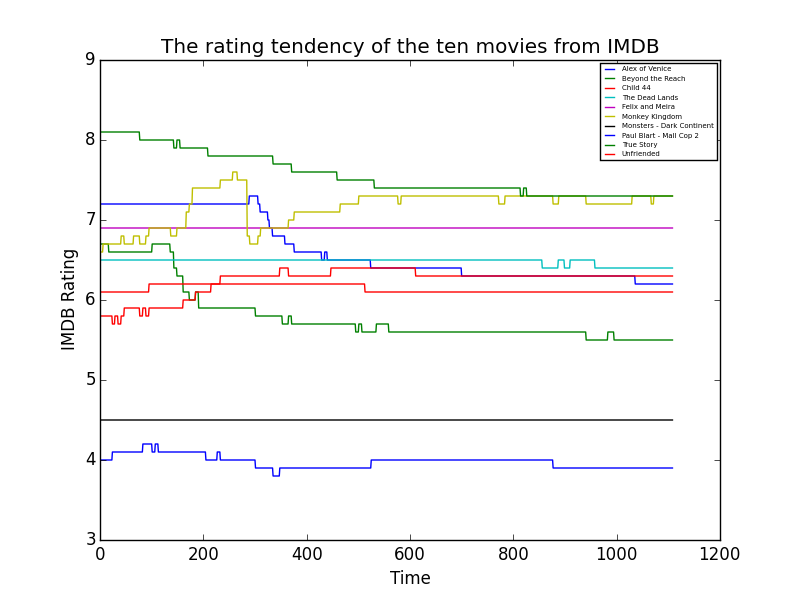

In [11]:
from IPython.display import Image
ten_movies = Image(filename='plots/ten_movies.png')
ten_movies

Plot each movie IMDb rating with tweet sentiment, both actual and trend (fitted)

In [12]:
def plot_tendency(imdb, tweet, movie_name, interval):
    # Average out the interval from 10 minutes to 'interval' (60 minutes)
    new_imdb = []
    to_average = interval/10
    for i in range(0, len(imdb), to_average):
        addition = len(imdb) - i
        if addition > to_average:
            addition = to_average
        total = 0
        for j in range(0, addition):
            total += imdb[i+j]
        new_imdb.append(total/to_average)

    new_tweet = []
    for i in range(0, len(tweet), to_average):
        addition = len(tweet) - i
        if addition > to_average:
            addition = to_average
        total = 0
        for j in range(0, addition):
            total += tweet[i+j]
        new_tweet.append(total/to_average)

    x_range = len(new_tweet)

    fig = plt.figure()
    my_xticks = ['']*(len(tweet)/to_average)
    my_xticks[0] = '04/16/2015 - 13:36:00'
    my_xticks[len(my_xticks)/2] = '04/18/2015 - 17:36:00'
    my_xticks[-1] = '04/20/2015 - 21:46:00'
    plt.xticks(range(0, (len(tweet)/to_average)), my_xticks)

    ax = fig.add_subplot(111)
    ax.plot(new_imdb, '-b', label='imdb_rating')
    ax2 = ax.twinx()
    ax2.plot(new_tweet, '-r', label='sentiment')
    
    # Fit the tweet data with linear regression
    regr = linear_model.LinearRegression()
    regr.fit(numpy.array(range(0, len(tweet)))[:, numpy.newaxis], numpy.array(tweet))
    
    ax2.plot(numpy.array(range(0, len(tweet)))[:, numpy.newaxis],
             regr.predict(numpy.array(range(0, len(tweet)))[:, numpy.newaxis]), color='green', linewidth=2,
             linestyle='--', label='fitted_sentiment')
    ax.legend(loc=2)
    ax2.legend(loc=1)
    
    # ax.grid()
    ax.set_ylim(-1, 11)
    # ax.set_ylim(min_rating - 0.5, max_rating + 0.5)
    ax2.set_ylim(-10, 110)
    ax.set_xlim(0, x_range)
    ax.set_xlabel("Time")
    ax.set_ylabel("IMDB Rating")
    ax2.set_ylabel("Sentiment Ratio")

    plt.title(movie_name)
    plt.savefig("plots/each_movie/" + movie_name)

In [13]:
if not os.path.exists('plots/each_movie'):
    os.makedirs('plots/each_movie')
    
interval = 60
for i in range(10):
    plot_tendency(imdb_data[i], sentiment_data[i], movie_names[i], interval)

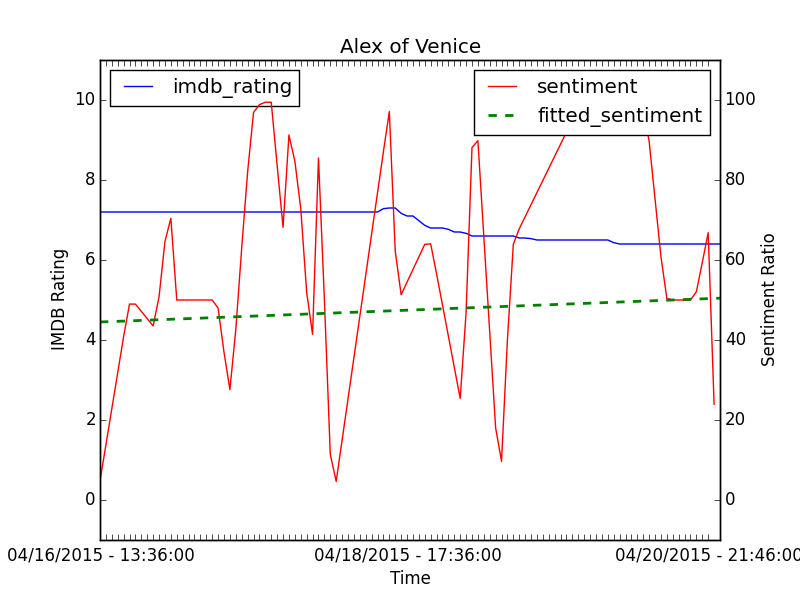

In [14]:
plot_movie0 = Image(filename='plots/each_movie/' + movie_names[0] + '.png')
plot_movie0

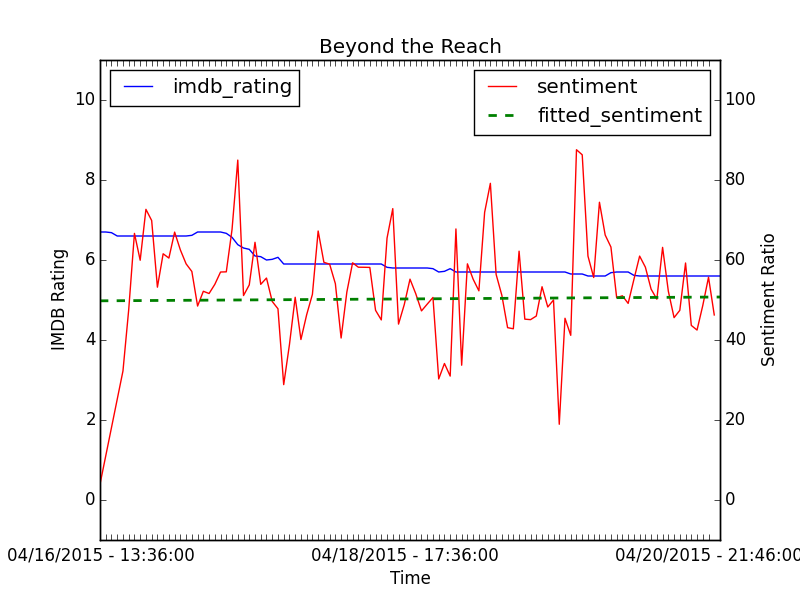

In [15]:
plot_movie1 = Image(filename='plots/each_movie/' + movie_names[1] + '.png')
plot_movie1

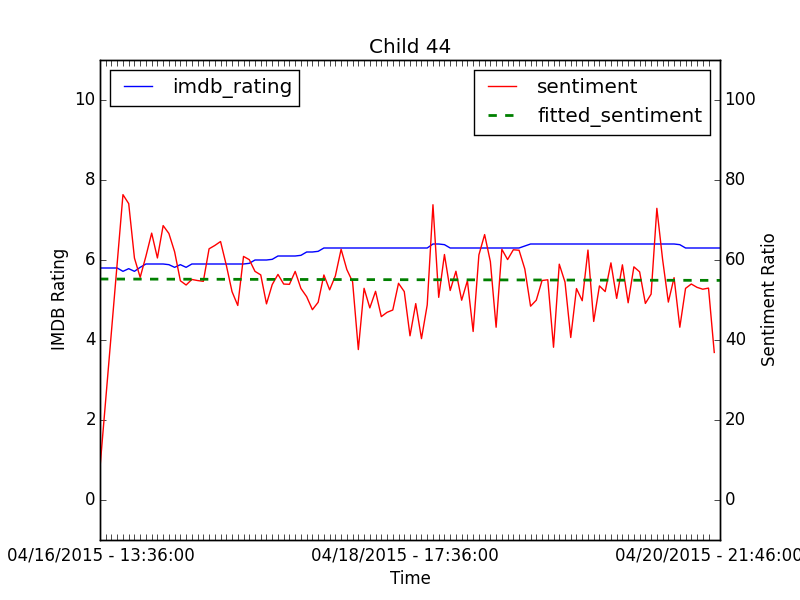

In [16]:
plot_movie2 = Image(filename='plots/each_movie/' + movie_names[2] + '.png')
plot_movie2

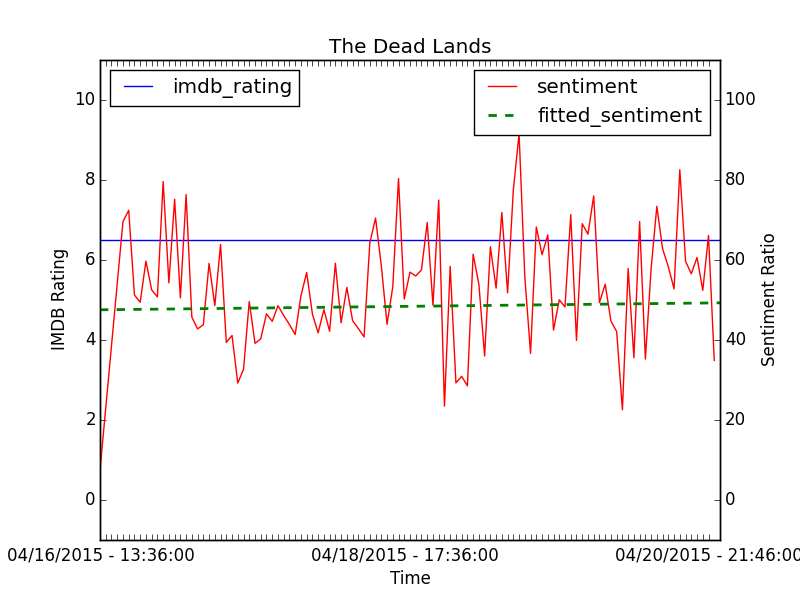

In [17]:
plot_movie3 = Image(filename='plots/each_movie/' + movie_names[3] + '.png')
plot_movie3

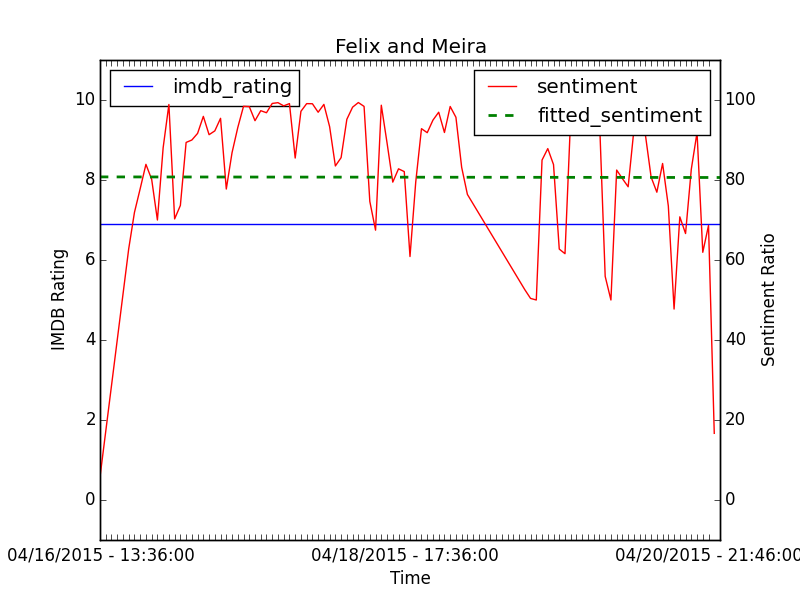

In [18]:
plot_movie4 = Image(filename='plots/each_movie/' + movie_names[4] + '.png')
plot_movie4

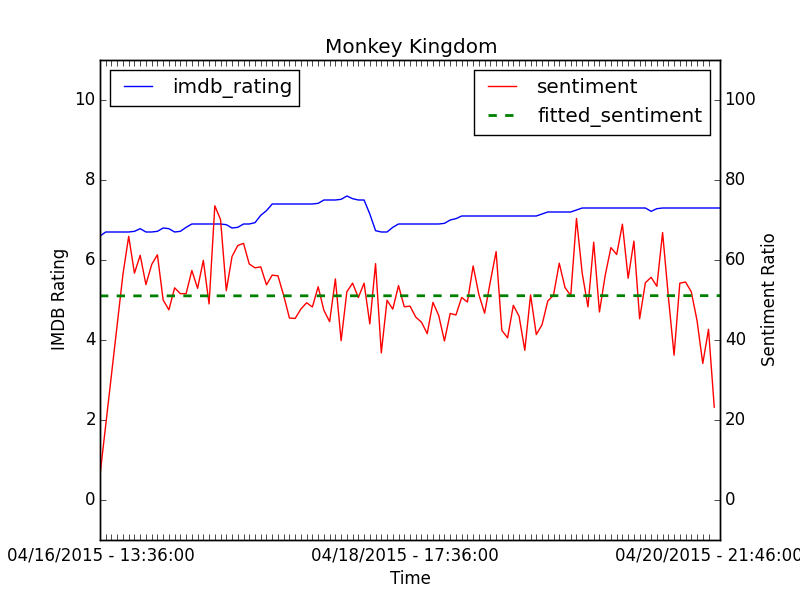

In [19]:
plot_movie5 = Image(filename='plots/each_movie/' + movie_names[5] + '.png')
plot_movie5

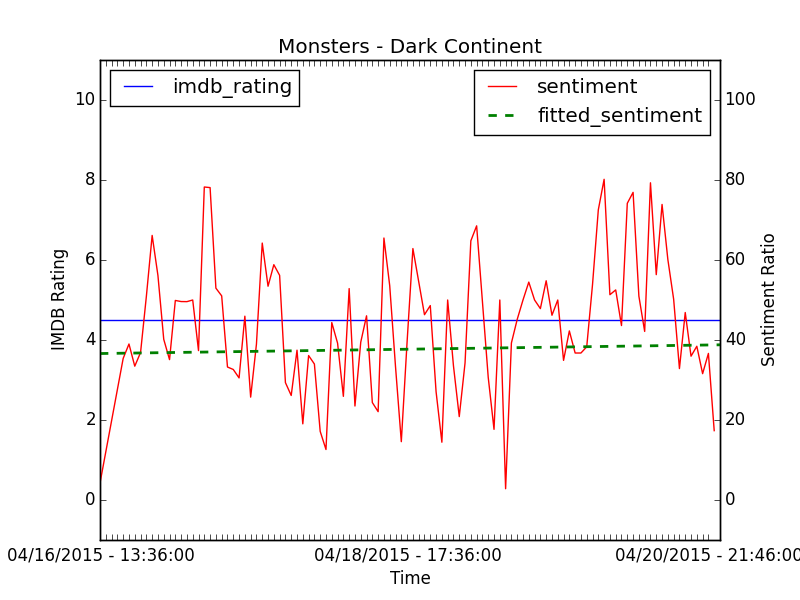

In [20]:
plot_movie6 = Image(filename='plots/each_movie/' + movie_names[6] + '.png')
plot_movie6

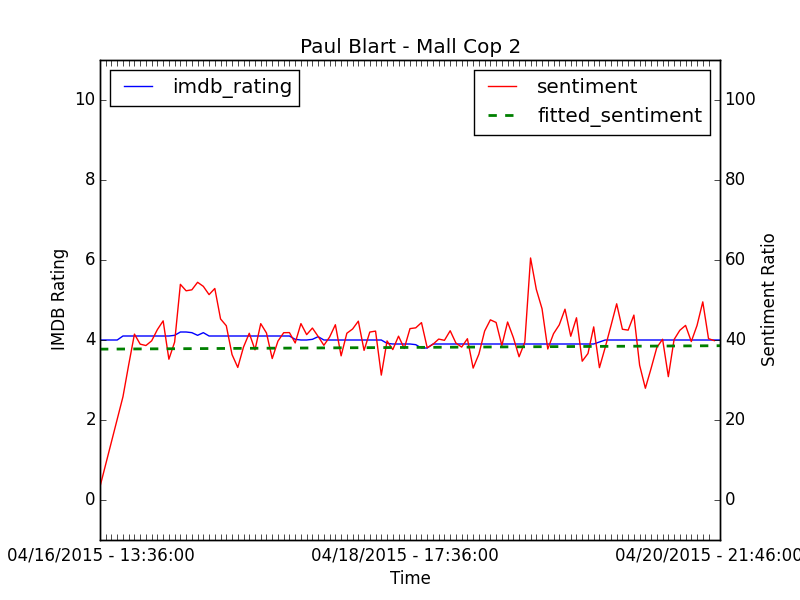

In [21]:
plot_movie7 = Image(filename='plots/each_movie/' + movie_names[7] + '.png')
plot_movie7

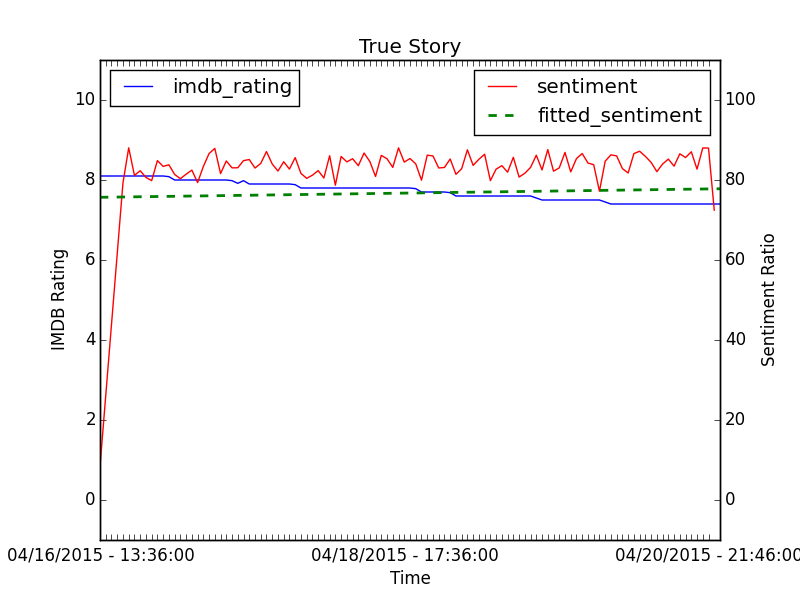

In [22]:
plot_movie8 = Image(filename='plots/each_movie/' + movie_names[8] + '.png')
plot_movie8

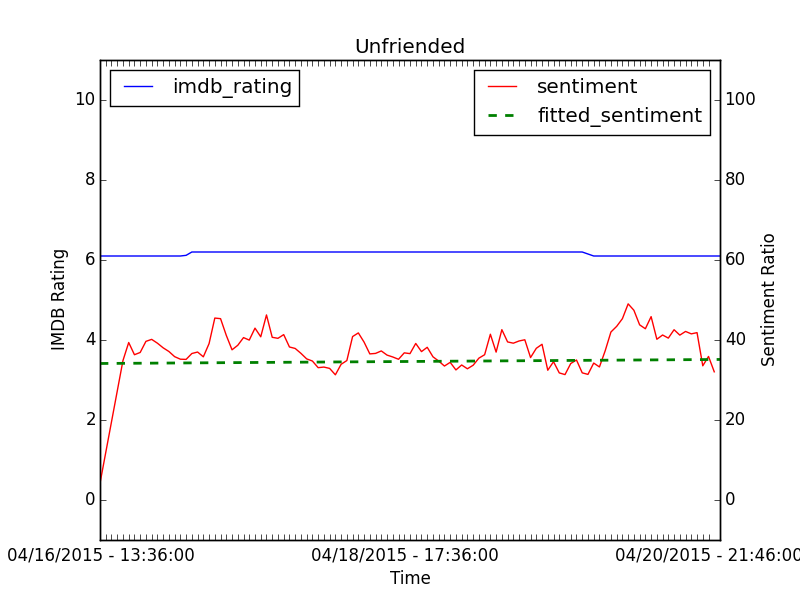

In [23]:
plot_movie9 = Image(filename='plots/each_movie/' + movie_names[9] + '.png')
plot_movie9

----------- FINISH PLOTTING DATA ------------------